# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

* Apply a distortion correction to raw images.

* Apply a perspective transform to rectify binary image ("birds-eye view").

* Use color transforms, gradients, etc., to create a thresholded binary image.

* Detect lane pixels and fit to find the lane boundary.

* Determine the curvature of the lane and vehicle position with respect to center.

* Warp the detected lane boundaries back onto the original image.

* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Step1, Camera Calibration using chessboard images

The opencv functions that will be used:

1.Get gray image

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

2.Finding chessboard corners (for an 8x6 board):

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

3.Drawing detected corners on an image:

img = cv2.drawChessboardCorners(img, (8,6), corners, ret)

4.Camera calibration

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

objpoints: 3D points in real world space

imgpoints:2D points in image plane

5.Undistorting a test image:

dst = cv2.undistort(img, mtx, dist, None, mtx)

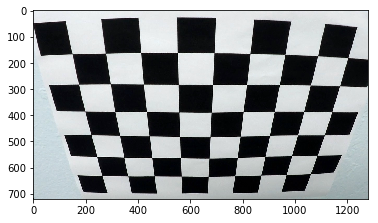

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

plt.imshow(img)

### 1. find corner points, create objpoints and imgpoints

In [2]:
import glob
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y


#Arrays to store object points and image points from all the images
objpoints = []  #3D points in real world space
imgpoints= []   #2D points in image plane
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = cv2.imread(fname)
     
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        


### 2.compute the camera calibration matrix(g_mtx) and distortion coefficients(g_dist)

In [3]:
# Read in an image
img = cv2.imread('./test_images/test5.jpg')
img_size = (img.shape[1],img.shape[0])
ret, g_mtx, g_dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

## step2: Apply a distortion correction to raw image

In [4]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

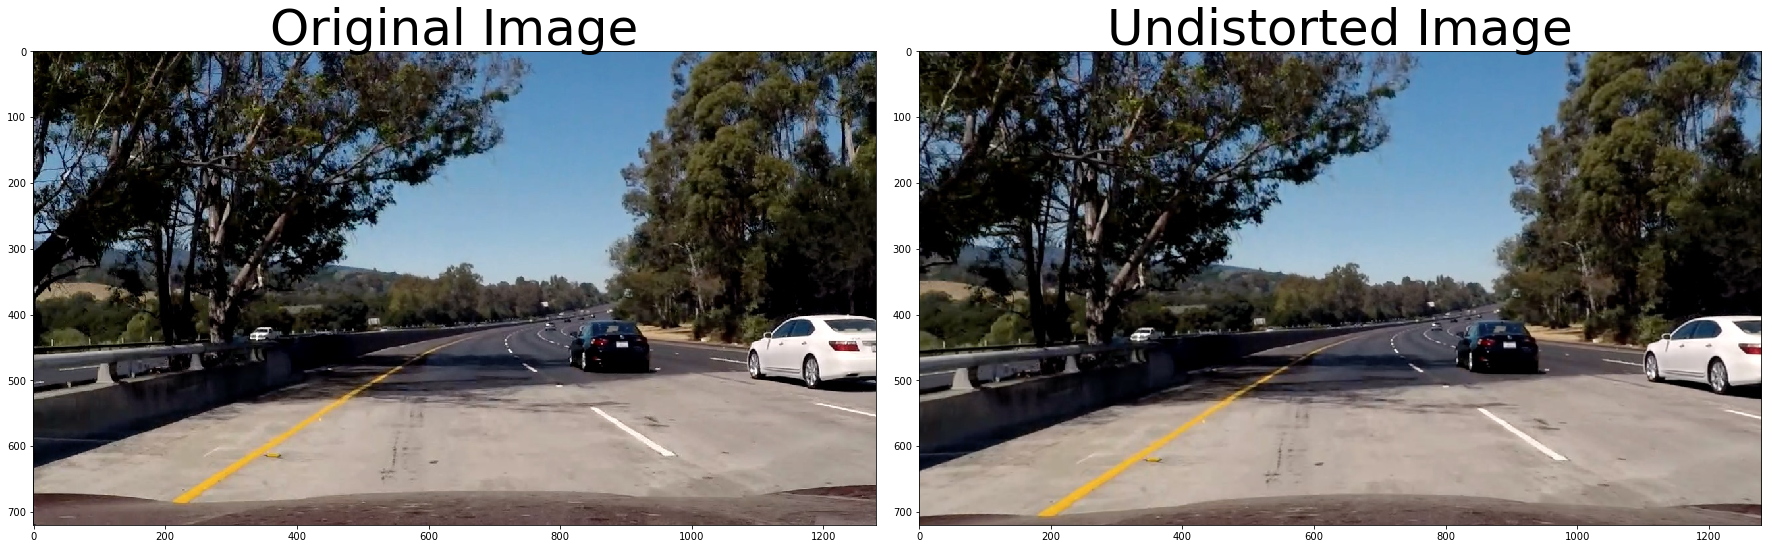

In [5]:
undistorted = cal_undistort(img, g_mtx, g_dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img[:,:,::-1])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[:,:,::-1])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/undistorted.jpg")

##  确定ROI

确定ROI(Region of interest),在当前车道线检测项目中,取一个梯形,目的有2:

1.剔除多余目标对车道线检测的干扰;

2.方便透视变换为bird-view图(从梯形转换为矩形);

In [6]:
'''
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print(img_size[0])
img = cv2.imread('./test_images/straight_lines1.jpg')
undistorted = cal_undistort(img, g_mtx, g_dist)

g_vertices =[[(576,408),(720,408),(1214,720), (120,720)]]
masked_edges = region_of_interest(undistorted,np.array(g_vertices,dtype=np.int32))
plt.imshow(masked_edges[:,:,::-1])

print(g_vertices)
'''


'\ndef region_of_interest(img, vertices):\n    """\n    Applies an image mask.\n    \n    Only keeps the region of the image defined by the polygon\n    formed from `vertices`. The rest of the image is set to black.\n    `vertices` should be a numpy array of integer points.\n    """\n    #defining a blank mask to start with\n    mask = np.zeros_like(img)   \n    \n    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image\n    if len(img.shape) > 2:\n        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image\n        ignore_mask_color = (255,) * channel_count\n    else:\n        ignore_mask_color = 255\n        \n    #filling pixels inside the polygon defined by "vertices" with the fill color    \n    cv2.fillPoly(mask, vertices, ignore_mask_color)\n    \n    #returning the image only where mask pixels are nonzero\n    masked_image = cv2.bitwise_and(img, mask)\n    return masked_image\n\nprint(img_size[0])\nimg = cv2.imread(\'./test

## step3: Apply a perspective transform to rectify binary image ("birds-eye view").



### 1.delimit ROI 

delimit src_corners(include lane line area)

In [7]:
wrap_offset = 150
src_corners = [(603, 445), (677, 445), (1105, 720), (205, 720)]
dst_corners = [(205 + wrap_offset, 0), (1105 - wrap_offset, 0), (1105 - wrap_offset, 720), (205 + wrap_offset, 720)]

### 2.get perspective transform matrix, and matrix_inv

In [8]:
g_M = cv2.getPerspectiveTransform(np.float32(src_corners),np.float32(dst_corners))
g_M_inv = cv2.getPerspectiveTransform(np.float32(dst_corners),np.float32(src_corners))
print(g_M)


[[-4.75203041e-01 -1.53225621e+00  9.47595473e+02]
 [-1.23460819e-15 -1.86625194e+00  8.30482115e+02]
 [-1.61630861e-18 -2.37889522e-03  1.00000000e+00]]


In [9]:
def pespective_transform(img_src, M, img_dst_size, flags=cv2.INTER_LINEAR):
    warped_img = cv2.warpPerspective(img_src, M, img_dst_size,flags=flags)
    
    return warped_img

### 3. Apply perspective transform to raw image, get warped image used for finding lane line after

In [10]:
g_warped = pespective_transform(undistorted,g_M,img_size,flags=cv2.INTER_LINEAR)

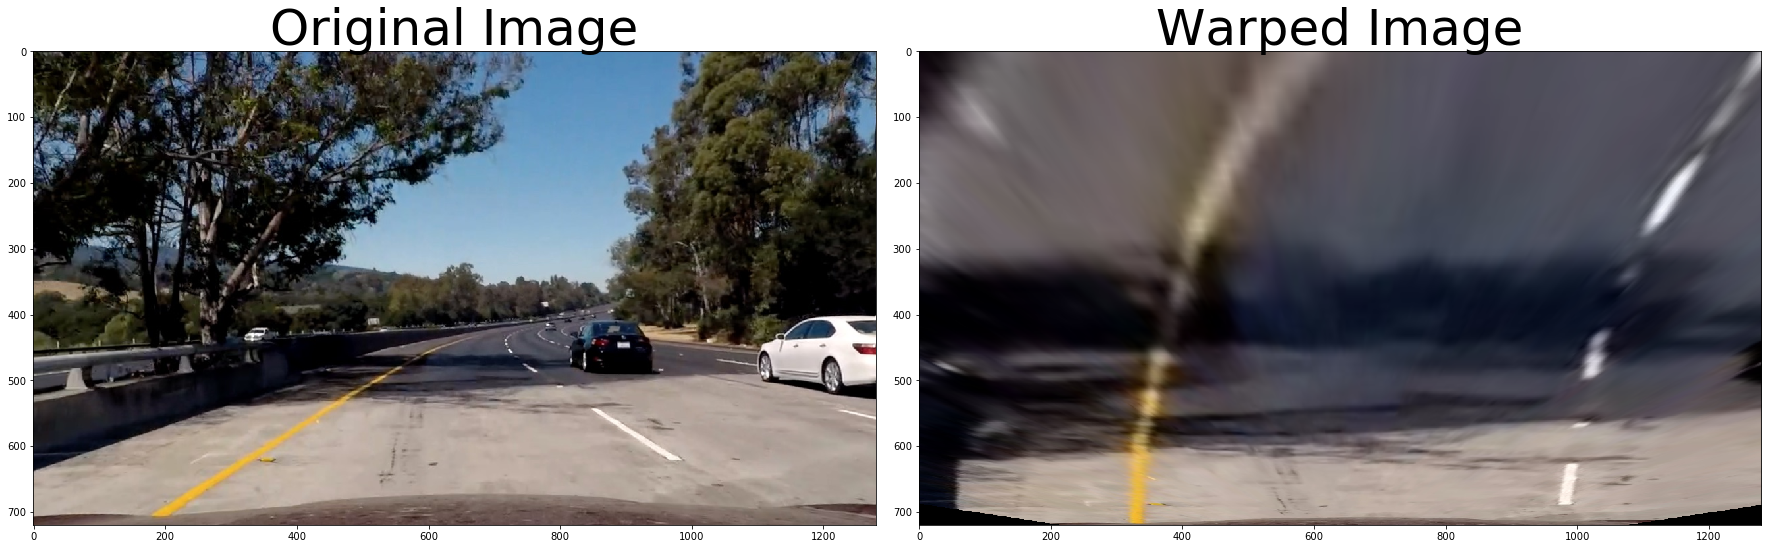

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted[:,:,::-1])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(g_warped[:,:,::-1])
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.show()
plt.savefig("output_images/warped.jpg")

## step4:Find lane line

Use color transforms, gradients, etc., to create a thresholded binary image.

In [12]:
def abs_sobel_thresh(img, orient,sobel_kernel=3,thresh=(0,255)):
    thresh_min,thresh_max= thresh
    #print(thresh_min,thresh_max)
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient =='x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    
    #print(abs_sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #print(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

In [13]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray,cmap='gray')
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    #print(gradmag.shape)
    #print(gradmag)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    
    # 6) Return this mask as your binary_output image
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [14]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(np.absolute(sobel_y),np.absolute(sobel_x))
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_grad_dir)
    
    # 6) Return this mask as your binary_output image
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    
    return binary_output

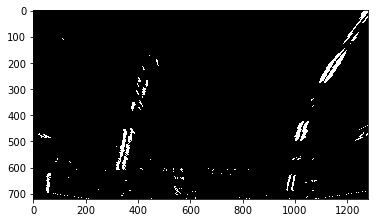

In [15]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(g_warped, orient='x', sobel_kernel=ksize, thresh=(20, 200))
grady = abs_sobel_thresh(g_warped, orient='y', sobel_kernel=ksize, thresh=(20, 200))
plt.imshow(gradx,cmap='gray')
plt.savefig("output_images/sobel.jpg")

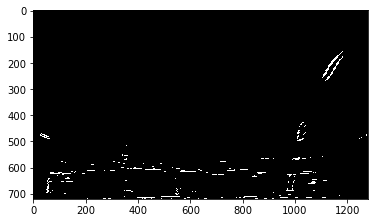

In [16]:
mag_binary = mag_thresh(g_warped, sobel_kernel=ksize, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')
plt.savefig("output_images/mag.jpg")

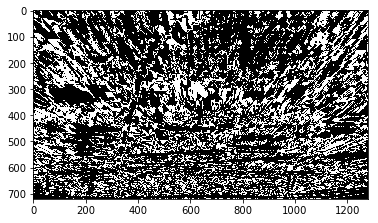

In [17]:
dir_binary = dir_threshold(g_warped, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary,cmap='gray')
plt.savefig("output_images/dir_threshold.jpg")

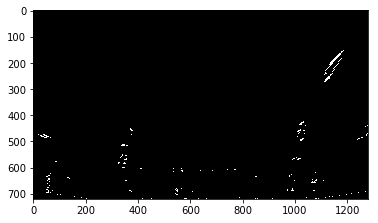

In [18]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined,cmap='gray')
plt.savefig("output_images/sobel_mag_dir_combined.jpg")

### 颜色空间阈值，取HLS空间的"S"信号:

因其在光线和车道颜色变化时依然有较好的区分度

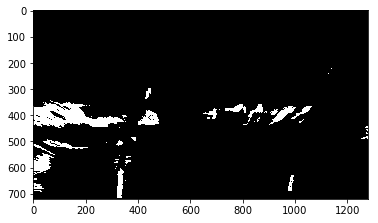

In [19]:
def color_binary(img,dst_format='HLS',ch=2,ch_thresh=[0,255]):
    '''
    Color thresholding on channel ch
    img:RGB
    dst_format:destination format(HLS or HSV)
    ch_thresh:pixel intensity threshold on channel ch
    output is binary image
    '''
    if dst_format =='HSV':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    else:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    return ch_binary
ch_thresh = [150,255]
ch3_hls_binary = color_binary(g_warped,dst_format='HLS',ch=3,ch_thresh=ch_thresh)
plt.imshow(ch3_hls_binary,cmap='gray')
plt.savefig("output_images/hls.jpg")

In [20]:
def combine_filters(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 255))
    ch3_l_binary = color_binary(img,dst_format='HLS',ch=2,ch_thresh=(100,255))
    ch3_s_binary = color_binary(img,dst_format='HLS',ch=3,ch_thresh=(100,255))

    
    combined_lsx = np.zeros_like(gradx)
    combined_lsx[((ch3_l_binary == 1) & (ch3_s_binary == 1) | (gradx == 1))] = 1
    return combined_lsx

(720, 1280)
(720, 1280, 3)
(720, 1280)


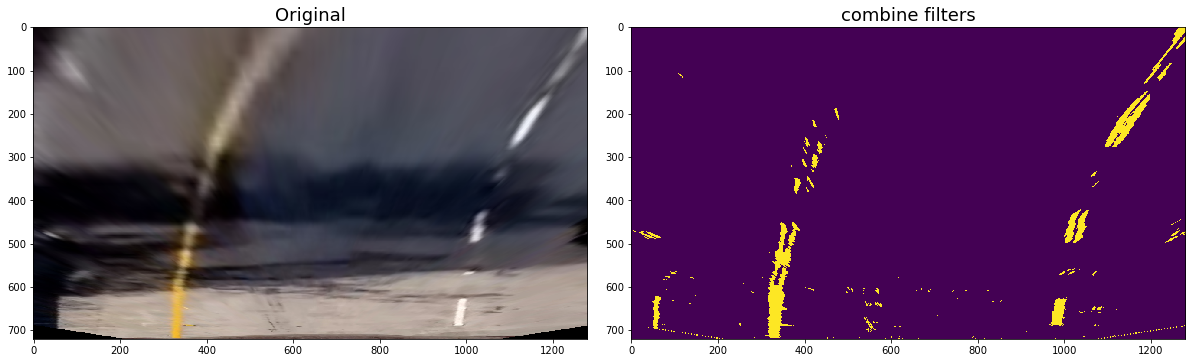

In [21]:
g_binary = combine_filters(g_warped)
print(g_binary.shape)
f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
print(g_warped.shape)
axs[0].imshow(g_warped[:,:,::-1])
axs[0].set_title('Original', fontsize=18)
#axs[1].imshow(g_binary, cmap='gray')[:,:,::-1]
print(g_binary.shape)
axs[1].imshow(g_binary)
axs[1].set_title('combine filters', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.show()

plt.savefig("output_images/sobel_hls_combined.jpg")

## step5&6: Detect lane pixels and fit to find the lane boundary and measure_curvature_real

#### 1, hist binary image

In [22]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    #print(bottom_half.shape)
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

<class 'numpy.ndarray'> (1280,)


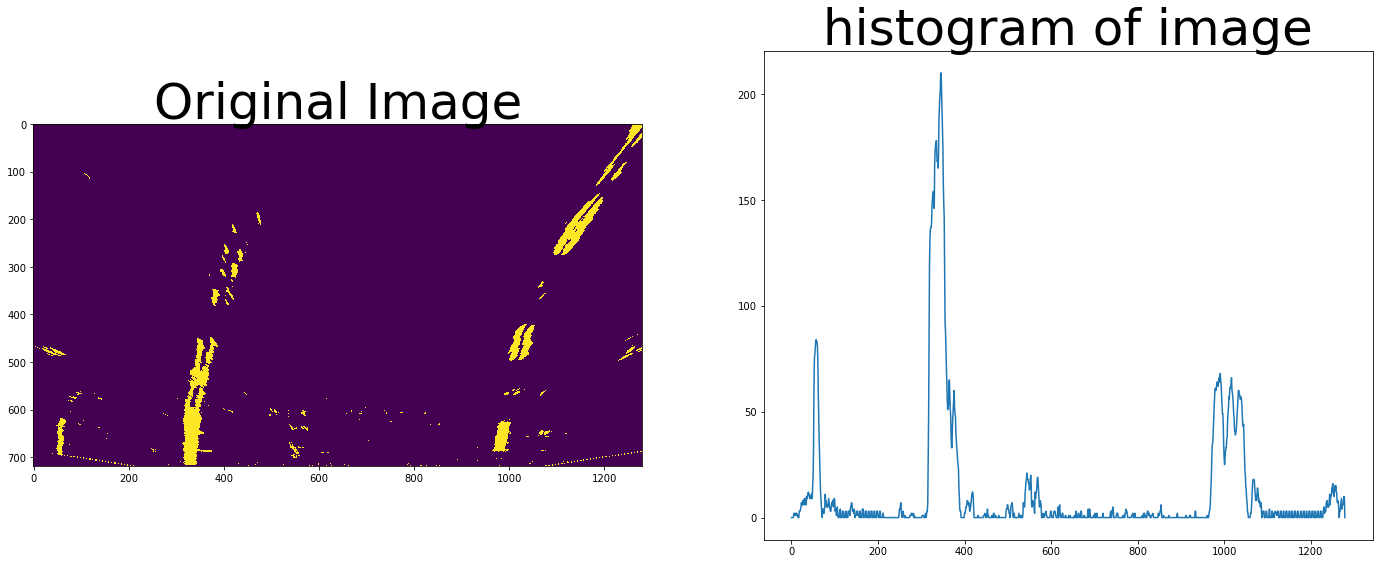

In [23]:
# Create histogram of image binary activations
histogram = hist(g_binary)
print(type(histogram),histogram.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.imshow(g_binary)
ax1.set_title('Original Image', fontsize=50)

#ax2.imshow(histogram)
#
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Visualize the resulting histogram
ax2.plot(histogram)
ax2.set_title('histogram of image', fontsize=50)
#plt.show()
plt.savefig("output_images/histogram.jpg")

#### 2: Implement Sliding Windows 

In [24]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    #step2.找到当前窗口的边界(由leftx_current,rightx_current，margin确定)；
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # 标定图像中所有非零的点坐标
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #step1:确定当前窗口边界
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #step2:画框
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        #step3:统计落入框内点数
        # Identify the nonzero pixels in x and y within the window #
        # good_left_inds:元组的第0个元素，该元素为一个数组，保存非零的索引
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        #print("good_left_inds",type(good_left_inds))
        #print("good_left_inds：",good_left_inds)
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # step5:框内点数超过minpix,更新框位置(取lane line像素点平均值作为新的x_current坐标)
        # If you found > minpix pixels, recenter next window on their mean position

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) #nonzerox[good_left_inds]符合条件的x坐标，再求均值
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

### 3 Fit a Polynomial

#### fit polynormial:

$f(y)=Ay^2 + By + C$

#### measure curvature real

$R_{curve}=\frac{[1+(2Ay+B)^2]^{\frac{3}{2}}}{2|A|} $

In [25]:
def measure_curvature_real(binary_warped,left_fit, right_fit):
    # Define y-value where we want radius of curvature
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension,in raw image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    curvature = ((left_curverad + right_curverad) / 2)
    #print(curvature)
    
    lanes_width = np.absolute(leftx[-1] - rightx[-1])
    lane_xm_per_pix = 3.7 / lanes_width #in pespective image
    
    veh_pos = (((leftx[-1] + rightx[-1]) * lane_xm_per_pix) / 2.)
    cen_pos = ((binary_warped.shape[1] * lane_xm_per_pix) / 2.)
    left_of_center = veh_pos - cen_pos
    return curvature,left_of_center

In [26]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
     ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

   

    # computer curverature and left of center
    curvature,left_of_center = measure_curvature_real(binary_warped,left_fit,right_fit)
    
    window_img = np.zeros_like(out_img)

    line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx, 
                      ploty])))])
    line_pts = np.hstack((line_window1, line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return out_img,left_fitx, right_fitx,ploty,curvature,left_of_center

In [27]:
g_out_img,left_fitx,right_fitx,ploty,Curvature,left_of_center = fit_polynomial(g_binary)
#mpimg.imsave('rectangle_line.png',out_img)

(572.1601328302612, 0.0) (329.9936965939346, 719.0)


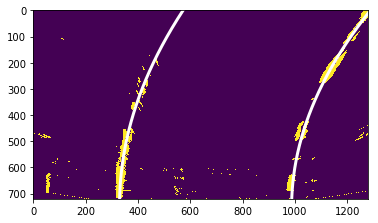

In [28]:
plt.imshow(g_binary)
plt.plot(left_fitx, ploty, color='white',linewidth=3.0)
plt.plot(right_fitx, ploty, color='white',linewidth=3.0)
plt.xlim(0,1280)
plt.ylim(720,0)
#plt.show()
plt.savefig("output_images/fit_polynomial.jpg")
print((left_fitx[0],ploty[0]),(left_fitx[-1],ploty[-1]))

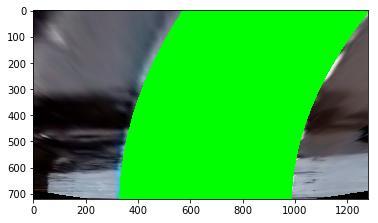

In [29]:
margin=20
test_img = np.copy(g_warped)
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
cv2.fillPoly(test_img, np.int_([left_line_pts]), (0,255, 0))

plt.imshow(test_img)
#plt.show()
plt.savefig("output_images/fillPoly.jpg")

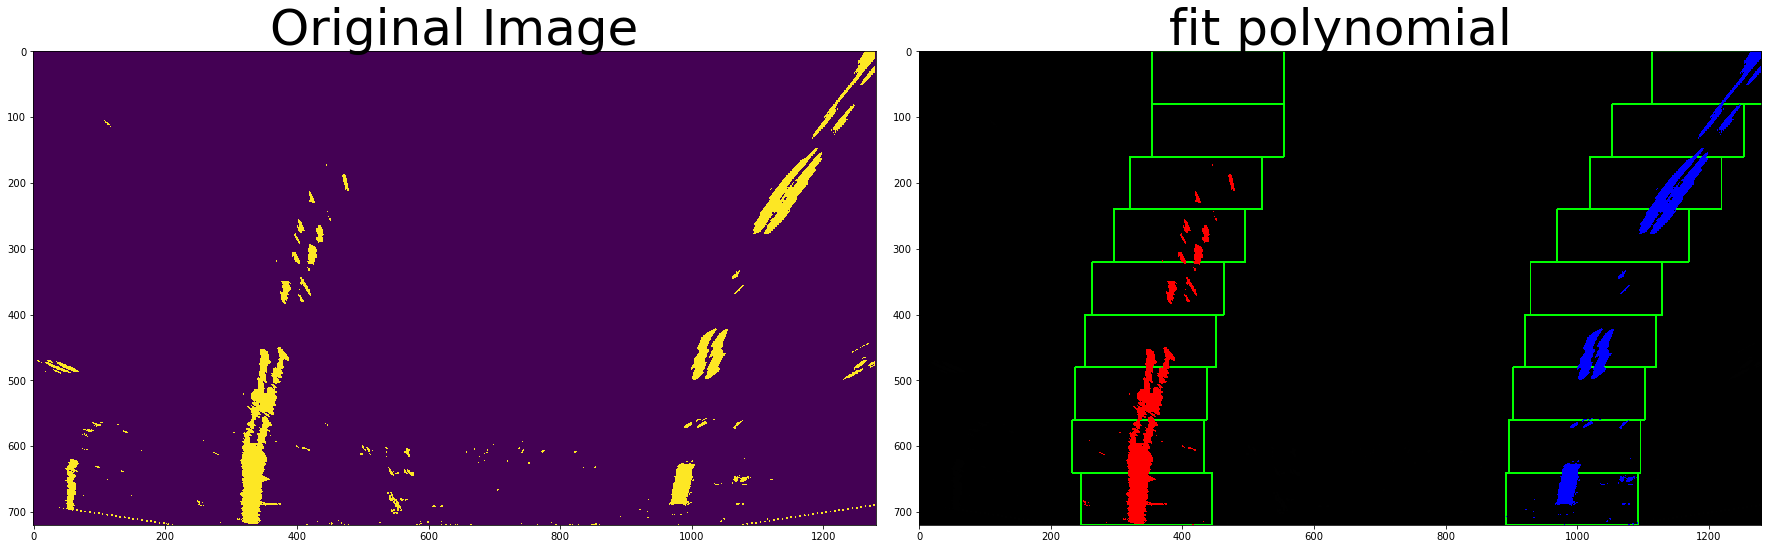

In [30]:

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(g_binary)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(g_out_img)
ax2.set_title('fit polynomial', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/slide_fit_polynomial.jpg")
plt.show()


In [31]:
print(g_binary.shape)

(720, 1280)


## step7: 画出车道线，转换回原图

## Perspective_back,  make image back into raw image

In [32]:
def perspective_back(wrap_img, origin_img, left_fitx, right_fitx, ploty, M):
    warp_zero = np.zeros_like(wrap_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (origin_img.shape[1],origin_img.shape[0])
    newwarp = cv2.warpPerspective(color_warp,M,img_size,flags=cv2.INTER_LINEAR)
    # Combine the result with the original image
    result = cv2.addWeighted(origin_img, 1, newwarp, 0.3, 0)
    return result




In [33]:
def display_img(img):
    fig = plt.figure(figsize=(16, 9))
    plt.imshow(img[:,:,::-1])

In [34]:
def Advanced_Lane_Finding(img, mtx, dist,M,M_inv):
    # 1.undistort
    undistorted_img = cal_undistort(img, g_mtx, g_dist)
    
    # 2. pespective
    img_size = (img.shape[1],img.shape[0])
    warped_img = pespective_transform(undistorted_img,M,img_size,flags=cv2.INTER_LINEAR)
    
    # 3. threshed
    binary_img = combine_filters(warped_img)
    
    #print(binary_img.shape)
    #f, axs = plt.subplots(1, 2, figsize=(16, 9))
    #f.tight_layout()
    #axs[0].imshow(warped_img)
    #axs[0].set_title('Original', fontsize=18)
    #axs[1].imshow(binary_img, cmap='gray')
    #axs[1].set_title('combine filters', fontsize=18)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #plt.show()
    

    # 4.
    out_img,left_fitx,right_fitx,ploty,Curvature,left_of_center= fit_polynomial(binary_img)
    #
    #5.
    out_img =perspective_back(binary_img,img,left_fitx,right_fitx,ploty,M_inv)
    
    str_curve = str("Radius of Curvature = {:.1f}(m)".format(Curvature))
    str_left_center= str("Vehicle is {:.2f}m left of center".format(left_of_center))

    cv2.putText(out_img,str_curve,(int(img.shape[1]/16),100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),4)
    cv2.putText(out_img,str_left_center,(int(img.shape[1]/16),160),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),4)
    #display_img(result)
    #out_img = project_back(g_binary, undistorted, left_fitx, right_fitx, ploty, M_inv)
    return out_img

In [35]:
img_cur = cv2.imread('./test_images/test1.jpg')
#print(img_cur.shape)
#display_img(img_cur)
result = Advanced_Lane_Finding(img_cur,g_mtx, g_dist,g_M,g_M_inv)

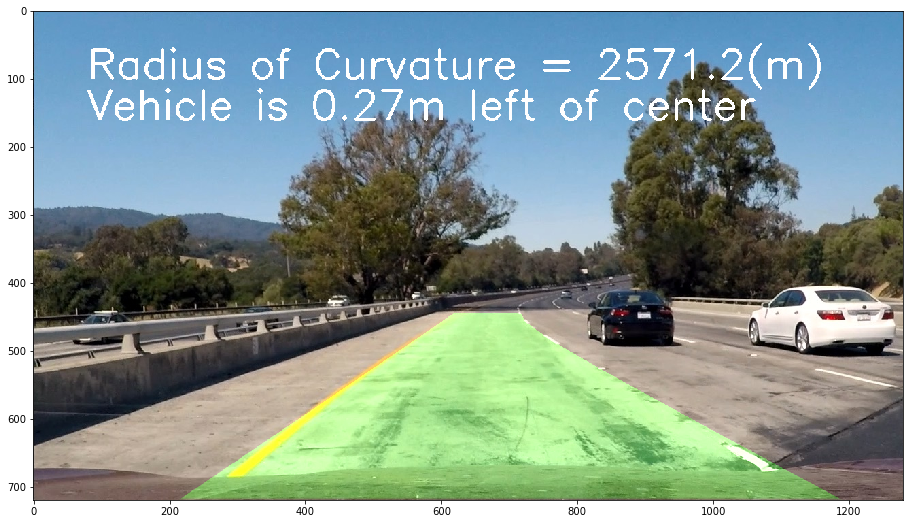

In [36]:
display_img(result)
plt.savefig("output_images/find_lane_line.jpg")

## step8: visual display on video

 Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [37]:
class process_image:
    def __init__(self,mtx, dist,M,M_inv):
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.M_inv = M_inv
    def __call__(self,image):
        #process
        #print(image.shape)
        image_new = Advanced_Lane_Finding(image,self.mtx,self.dist,self.M,self.M_inv)
        return image_new

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
project_video_output = 'output_videos/project_new.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/project_video.mp4")
#result = Advanced_Lane_Finding(img_cur,g_mtx, g_dist,g_M,g_M_inv)
project_clip = clip1.fl_image(process_image(g_mtx, g_dist,g_M,g_M_inv)) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False),

t:   0%|          | 3/1260 [00:00<00:43, 29.04it/s, now=None]

Moviepy - Building video output_videos/project_new.mp4.
Moviepy - Writing video output_videos/project_new.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_new.mp4
CPU times: user 2min 22s, sys: 20.5 s, total: 2min 43s
Wall time: 53.3 s


(None,)

In [40]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## for challenge video

In [56]:
challenge_video_output = 'output_videos/challenge_new.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("test_videos/challenge_video.mp4")
#result = Advanced_Lane_Finding(img_cur,g_mtx, g_dist,g_M,g_M_inv)
challenge_clip = clip2.fl_image(process_image(g_mtx, g_dist,g_M,g_M_inv)) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_video_output, audio=False),

t:   1%|          | 3/485 [00:00<00:25, 19.19it/s, now=None]

Moviepy - Building video output_videos/challenge_new.mp4.
Moviepy - Writing video output_videos/challenge_new.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_new.mp4
CPU times: user 2min 39s, sys: 13.8 s, total: 2min 53s
Wall time: 32.4 s


(None,)

In [57]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

## for harder_challenge video

In [58]:
harder_challenge_output = 'output_videos/harder_challenge_new.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
#result = Advanced_Lane_Finding(img_cur,g_mtx, g_dist,g_M,g_M_inv)
harder_challenge_clip = clip1.fl_image(process_image(g_mtx, g_dist,g_M,g_M_inv)) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False),

t:   0%|          | 3/1199 [00:00<00:59, 19.94it/s, now=None]

Moviepy - Building video output_videos/harder_challenge_new.mp4.
Moviepy - Writing video output_videos/harder_challenge_new.mp4



Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_new.mp4
CPU times: user 7min 3s, sys: 34.1 s, total: 7min 37s
Wall time: 1min 27s


(None,)

In [59]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))